# Explicando modelos

Uma das preocupações com utilização de modelos de machine learning é como utiliza-lo para tomada de decisão no mundo real. Isso não é um problema quando temos modelos simples, porém modelos mais complexos (as famosas caixas pretas) acabam perdendo essa capacidade de serem explicados/interpretados devido a algumas características como alta dimensionalidade, não linearidade, utilização de muitos parametros, etc.

Para resolver esse problema podemos utilizar algumas técnicas, e aqui veremos duas:
- SHapley Additive exPlanations (SHAP)
- Local Interpretable Model-agnostic Explanations (LIME) 

# 1.Importando bibliotecas e conjunto de dados

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lime
import shap
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('data/gastos_saude.csv')

# 2.Pré-Processamento

In [3]:
X = df.drop(columns=['expenses'])
Y = df['expenses']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

In [4]:
processador_num = Pipeline([(
    's_scaler', StandardScaler()
)])

processador_cat = Pipeline([(
    'oh_encoder', OneHotEncoder(drop='if_binary')
)])

processador = ColumnTransformer(transformers = [
    ('processador_num', processador_num, num_cols),
    ('processador_cat', processador_cat, cat_cols)
], remainder='passthrough', verbose_feature_names_out=False)

X_train_preproc = pd.DataFrame(
    processador.fit_transform(X_train),
    columns=processador.get_feature_names_out()
)

X_test_preproc = pd.DataFrame(
    processador.fit_transform(X_test),
    columns=processador.get_feature_names_out()
)

# 3.Modelo - Random Forest Regressor

Vamos utilizar o Random Forest Regressor. Este modelo utiliza um conjunto de árvores de decisão para tomar decisões individuais e, em seguida, combina essas decisões para criar um modelo com melhores métricas de desempenho.

In [5]:
rfr = RandomForestRegressor(max_depth=3, random_state=42)
rfr.fit(X_train_preproc, y_train)
y_pred_rfr = rfr.predict(X_test_preproc)
r_quad_rfr = rfr.score(X_test_preproc, y_test).round(3)
print(f"R² para RandomForestRegressor para teste: {r_quad_rfr}")

R² para RandomForestRegressor para teste: 0.861


# 4.LIME

O LIME (Explicações Locais Interpretáveis de Modelo Agnóstico) concentra-se principalmente em fornecer interpretabilidade local para previsões individuais feitas por um modelo de aprendizado de máquina. Ele foi projetado para explicar por que um modelo específico fez uma determinada previsão para uma única instância ou observação. O LIME faz isso aproximando o comportamento do modelo nas proximidades da instância que você está interessado em explicar.

In [6]:
# selecionar nomes das colunas
variaveis = X_train_preproc.columns

# Criando objeto LimeTabularExplainer, com os dados necessários
explicador = LimeTabularExplainer(X_train_preproc.values, 
                                  feature_names=variaveis,
                                  verbose=True,
                                  mode='regression')


In [7]:
# Escolhendo qual observação vamos interpretar
instance_to_explain = X_test_preproc.iloc[0]

# Usando o método "explain_instance()" para trazer as informações sobre a contribuição de cada variável para essa previsão
explicacao = explicador.explain_instance(
    instance_to_explain, rfr.predict
)

Intercept 32017.17866935359
Prediction_local [8232.87338702]
Right: 9732.455510743013


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Temos como resposta o intercepto a previsão feita pelo modelo e o valor real

O objeto criado possui o método "show_in_notebook()" que explica como chegamos a uma previsão em particular baseada na contribuição de cada variável.

In [8]:
# Visualizando explicação para observação selecionada
explicacao.show_in_notebook()

Podemos notar uma barra barra de progresso, um gráfico de barras e uma tabela. A barra mostra a faixa de variação de valores e a previsão feita. O gráfico de barras mostra as variáveis que contribuiram positiva (aumentam o valor gasto) e negativamente (diminuem o valor gasto) para a previsão e a tabela mostra a contribuição das variáveis.

In [9]:
# from IPython.display import HTML

# # possível visualizar em html
# html_data = explicacao.as_html()
# HTML(data=html_data)

In [10]:
# Salvando explicação em html
# explicacao.save_to_file("data/regress_explicacao.html")

Usando o método "as_pyplot_figure()" como abaixo podemos obter o gráfico de barras da contribuiçaõ de cada variável para a observação em questão

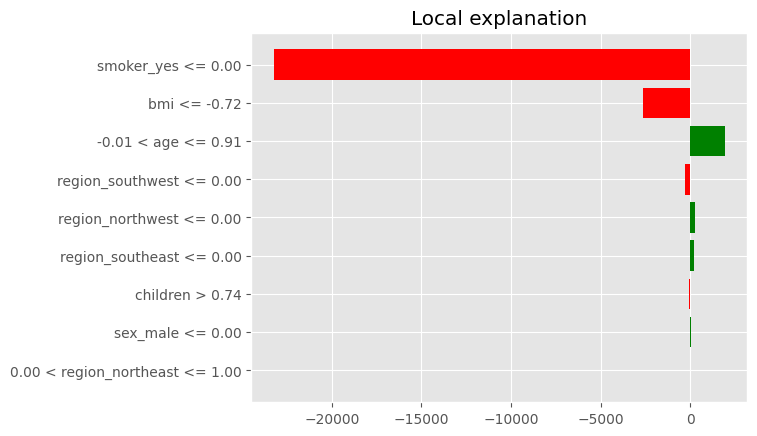

In [11]:
with plt.style.context('ggplot'):
    explicacao.as_pyplot_figure()
    plt.show()

Podemos usar o método "as_list()" no objeto, que retorna a explicação como uma lista de tuplas, onde o primeiro valor da tupla é a condição e o segundo valor é a contribuição do valor da característica com base na condição.

In [12]:
explicacao.as_list()

[('smoker_yes <= 0.00', -23220.18336377802),
 ('bmi <= -0.72', -2625.7699478614963),
 ('-0.01 < age <= 0.91', 1939.1095578011532),
 ('region_southwest <= 0.00', -282.94031957370134),
 ('region_northwest <= 0.00', 269.6161548472467),
 ('region_southeast <= 0.00', 192.49527609514053),
 ('children > 0.74', -92.55128285332626),
 ('sex_male <= 0.00', 71.89244828267242),
 ('0.00 < region_northeast <= 1.00', -35.9738052975884)]

In [13]:
print("Explicação Local Prediction (previsão feita pelo LIME):", explicacao.local_pred[0])
print("Explicação Global Prediction (previsão feita pelo modelo):", explicacao.predicted_value)

Explicação Local Prediction (previsão feita pelo LIME): 8232.87338701568
Explicação Global Prediction (previsão feita pelo modelo): 9732.455510743013


# 5.SHAP

A biblioteca SHAP permite que sejam feitas análises globais e locais do modelo, ou seja é possível entender a importancia e influencia de cada variável para modelo quanto para cada observação.

In [14]:
# Criar um objeto "explicador" usando os dados de treino
explicador_shap = shap.Explainer(rfr, X_train_preproc)

# Computar valores SHAP para dados de teste
shap_values = explicador_shap(X_test_preproc)

## Avaliação global

### Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


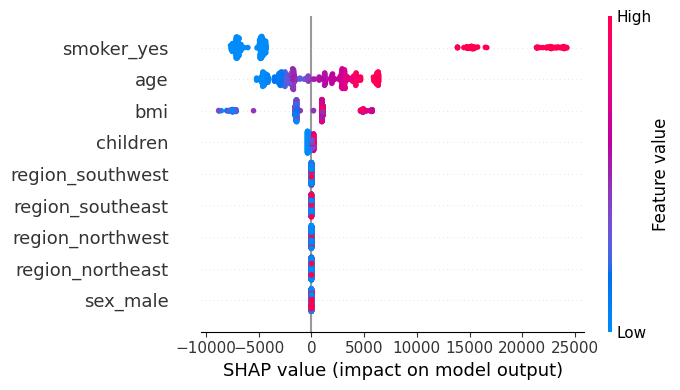

In [15]:
# Plotar predição para o modelo
shap.summary_plot(shap_values, X_test_preproc, plot_size=(7, 4))
plt.show()

Com essa ferramenta possível visualizar a importancia de cada variável e seu impacto na previsão. Ele resume o peso de cada variável pela magnitude dos valores SHAP para todas as observações.

O gráfico acima mostra que:
- "smoker_yes" tendo valores altos empurra o valor da predição para valores maiores (fumar faz você gastar mais dinheiro)
- "age" com valores mais altos empurra o valor da predição para valores maiores (ter mais idade faz você gastar mais dinheiro)
- "bmi" com valores mais altos empurra o valor da predição para valores maiores (ter maior IMC faz você gastar mais dinheiro)
- as variáveis restantes não contribuem de maneira significativa para impactar no valor previsto (considerando todo o modelo)

### Violin Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


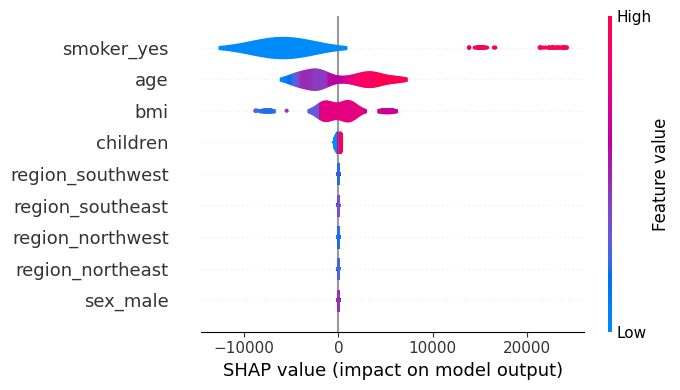

In [16]:
# Podemos também visualizar o mesmo gráfico de outra maneira
shap.summary_plot(shap_values, X_test_preproc,
                  plot_type='violin', plot_size=(7, 4))

### Bar

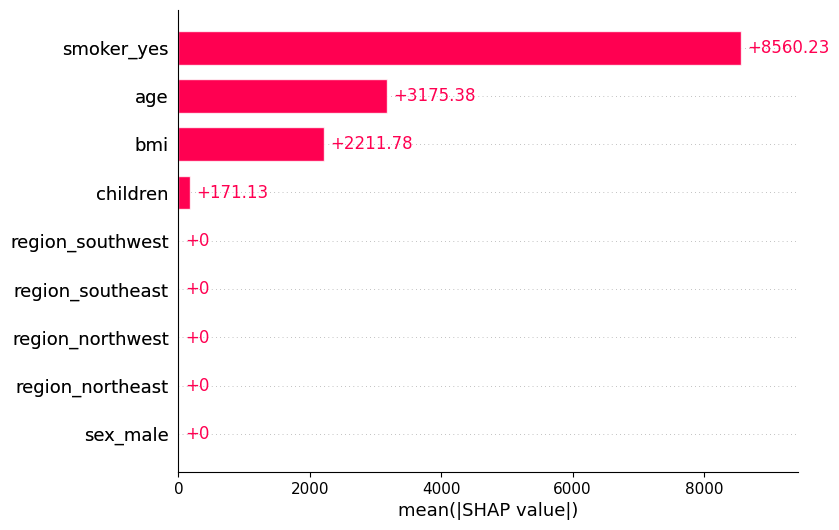

In [17]:
shap.plots.bar(shap_values)

Aqui as variáveis estão ordenadas de forma descendente em relação ao efeito na previsão. Leva em conta o valor SHAP absoluto, então nesse caso não importa se a variável afeta a previsão de maneira positiva ou negativa.

## Avaliação Local

### Bar

Parecido com o codigo anterior temos somente que adicionar a observação que queremos analisar.

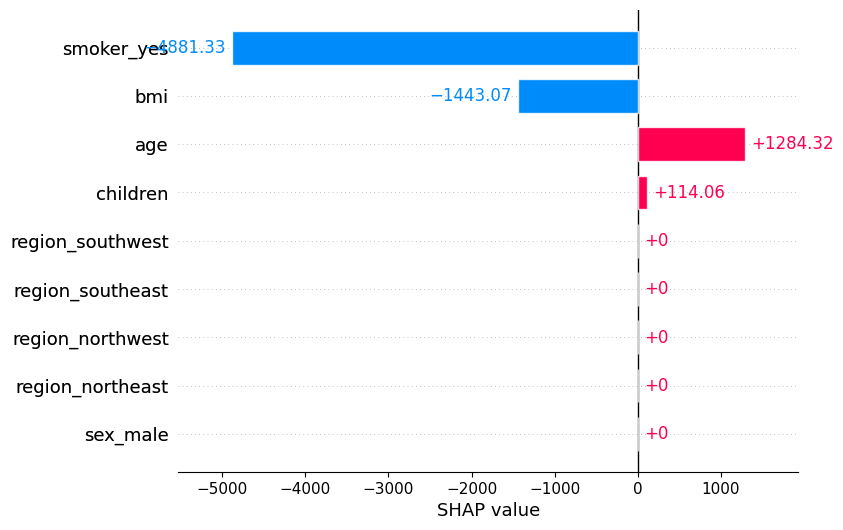

In [18]:
shap.plots.bar(shap_values[0])

O gráfico acima mostra quais as principais variáveis afetando a previsão individual e a magnitude do valor SHAP para cada variável.

### Waterfall

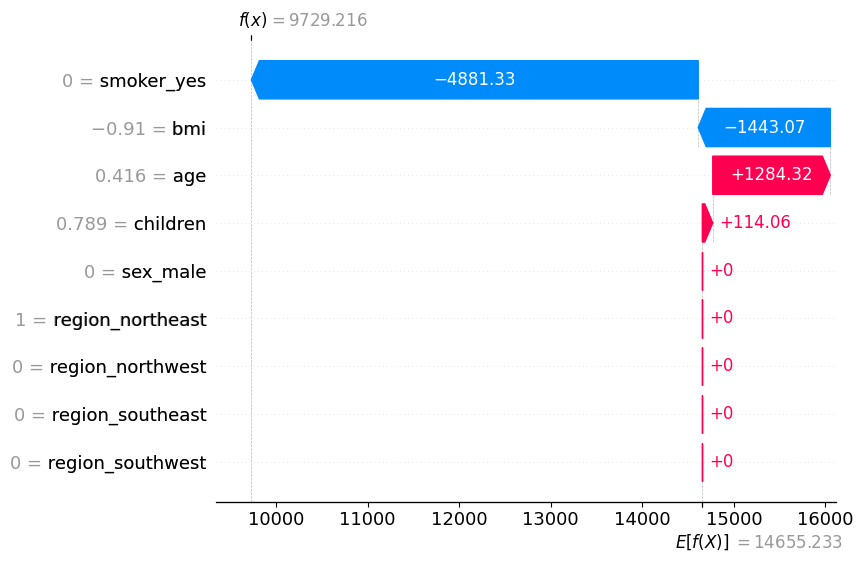

In [19]:
# Plotar valores SHAP para uma observação/previsão
shap.plots.waterfall(shap_values[0])

O gráfico acima tem as mesmas informações representadas no gráfico anterior porém de maneira diferente. Podemos ver como a soma de todos os valores SHAP é igual à diferença entre a previsão f(x) e o valor esperado E[f(x)].

### Force Plot

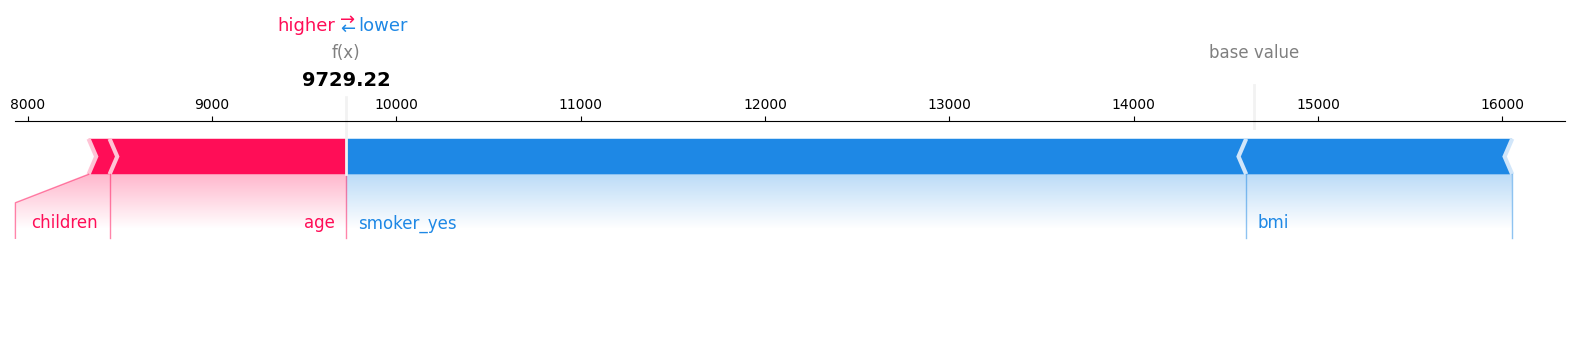

In [20]:
# Calcular valores SHAP para uma observação
sample_instance = X_test_preproc.iloc[0]
shap_values = explicador_shap.shap_values(sample_instance)

# Criar um objeto de "explicação"
explanation = shap.Explanation(values=shap_values, 
                               base_values=explicador_shap.expected_value)

# Plotforce para explicar resultado (matplotlib=True para usar matplotlib)
shap.plots.force(explanation, matplotlib=True, feature_names=variaveis)
plt.show()

Para essa observação "X_test_preproc.iloc[0]" o forceplot mostra que as variáveis "children" e "age" estão empurrando a previsão para valores mais altos enquanto as variáveis "smoker_yes" e "bmi" estão empurrando a previsão para valores mais baixos.

### Dependence Plot

Podemos também visualizar como a previsão do modelo é influenciada por uma unica variável

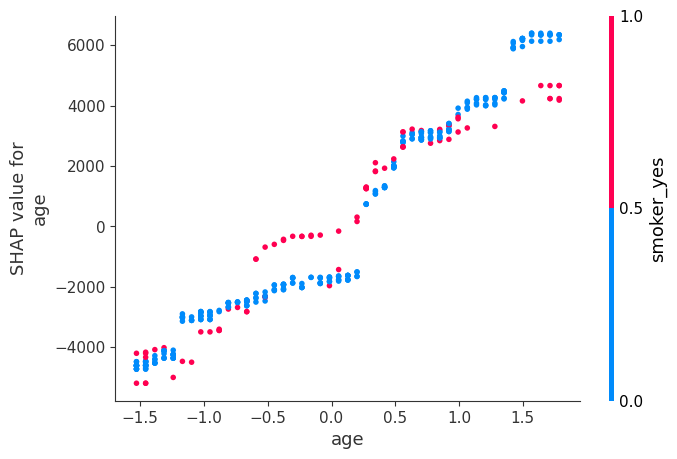

In [21]:
shap.dependence_plot(0, explicador_shap.shap_values(X_test_preproc), X_test_preproc)

### Decision Plot

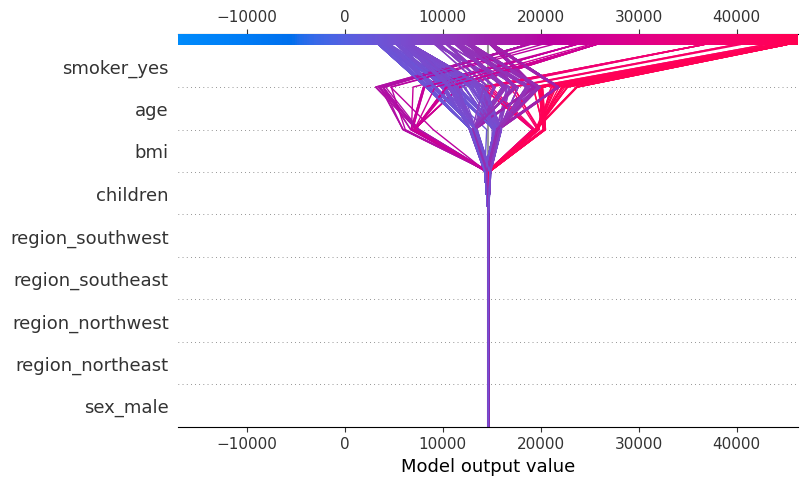

In [22]:
shap.decision_plot(explicador_shap.expected_value, 
                   explicador_shap.shap_values(X_test_preproc), 
                   X_test_preproc.columns)

# 6.Conclusão

Existem diversas bibliotecas que podem ser usadas para tentar desvendar o comportamento de modelos considerados "caixa-preta".
Com SHAP e LIME é possível entender a tomada de decisão do nosso modelo tanto de forma global quanto de forma individual a cada observação.
Essas ferramentas permitem observar como são tomadas as decisões do modelo e como isso pode impactar os resultados obtidos, sendo uma ferramenta de muita ajuda ao lidar com modelos mais poderosos.

# Referencia

- https://github.com/marcotcr/lime
- https://lime-ml.readthedocs.io/en/latest/index.html
- https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/
- https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
- https://medium.com/big-data-blog/shap-o-que-%C3%A9-e-por-que-usar-6b01d37ae592
- https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
- https://medium.com/analytics-vidhya/model-interpretability-lime-part-2-53c0f5e76b6a
- https://betterdatascience.com/shap/
- https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137